# The Endogenous Grid Method


**Prepared for the Bank of Portugal Computational Economics Course (Oct 2025)**

**Author:** [John Stachurski](https://johnstachurski.net)

## Overview

In this lecture we use the endogenous grid method (EGM) to solve a basic income
fluctuation (household optimal savings) problem.

To keep things simple, the interest rate will be constant and labor income will
be IID.


In [1]:
!pip install quantecon  # Uncomment if necessary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.7/325.7 kB 10.3 MB/s eta 0:00:00


We will use the following imports.

In [2]:
import quantecon as qe
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
import numba
from time import time
from typing import NamedTuple

Let’s check the GPU we are running

In [3]:
!nvidia-smi

Fri Oct 10 09:19:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Let's use 64 bit floating point numbers for extra precision.

In [4]:
jax.config.update("jax_enable_x64", True)

## Setup

We consider a household that chooses a consumption plan $ \{c_t\}_{t \geq 0} $ to maximize

$$
    \mathbb{E} \, \sum_{t=0}^{\infty} \beta^t u(c_t)
$$

subject to

$$
    a_{t+1} \leq  R(a_t - c_t)  + Y_{t+1},
    \quad c_t \geq 0,
    \quad a_t \geq 0
    \quad t = 0, 1, \ldots
$$

Here $ R = 1 + r $ where $ r $ is the interest rate.

To make our life simple, the income process $ \{Y_t\} $ will be IID and
lognormal:

$$
    Y_t = \exp(\mu + \sigma Z_t)
    \quad \text{with} \quad
    Z_t ~ N(0,1)
$$

Utility has the CRRA specification

$$
u(c) = \frac{c^{1 - \gamma}} {1 - \gamma}
$$

Here's a Model class to store parameters and arrays.

In [5]:
class Model(NamedTuple):
    β: float            # discount factor
    R: float            # gross interest rate
    γ: float            # CRRA preference parameter
    μ: float            # income location parameter
    ν: float            # income volatility parameter
    s_array: jax.Array  # savings grid
    y_draws: jax.Array  # income draws for Monte Carlo

This function creates an instance with default parameter values.


In [6]:
def create_model(R=1.01,             # gross interest rate
                 β=0.98,             # discount factor
                 γ=1.5,              # CRRA preference parameter
                 μ=-1.0,             # income location parameter
                 ν=0.2,              # income volatility parameter
                 s_max=16,           # savings grid max
                 s_size=500,         # savings grid size
                 y_size=2_000,       # number of income draws
                 seed=42):           # random seed
    """
    Builder function for Model class.

    """
    # require R β < 1 for convergence
    assert R * β < 1, "Stability condition failed."

    # Create savings grid
    s_array = jnp.linspace(0, s_max, s_size)

    # Generate income draws for Monte Carlo integration
    key = jax.random.PRNGKey(seed)
    z_draws = jax.random.normal(key, (y_size,))
    y_draws = jnp.exp(μ + ν * z_draws)

    # Return Model instance
    return Model(
        β=β, R=R, γ=γ, μ=μ, ν=ν, s_array=s_array, y_draws=y_draws
    )

## Solution method

The state $a_t$ takes values in $\mathbb R_+$.

We aim to compute an optimal consumption policy $\sigma^* \colon S \to S$, under which dynamics are given by

$$
    c_t = \sigma^*(a_t)
    \quad \text{and} \quad
    a_{t+1} = R (a_t - c_t) + Y_{t+1}
$$

### Euler equation

The Euler equation for the optimization problem is

$$
u' (c_t)
    = \max
    \left\{
        \beta R \,  \mathbb{E}_t  u'(c_{t+1})  \,,\;  u'(a_t)
    \right\}
$$

(An explanation for this expression can be
found [here](https://python.quantecon.org/ifp.html#value-function-and-euler-equation).)

Let a consumption policy $\sigma$ be given.

Our task is to update it to the next guess.

We fix an *exogenous* grid of current saving values $0 = s_0 < \ldots < s_{N-1}$

(Savings is related to assets and consumption by $s = a - c$.)

Using the exogenous savings grid, we will create an

1. a consumption grid $ c_0, \ldots, c_{N-1} $ and
2. *endogenous* asset grid $ a_0, \ldots, a_{N-1}$

such that these pairs satisfying the Euler equation.

When then interpolate these pairs to obtain the new policy guess $\sigma'$.

Here are the steps:

First we set $a_0 = c_0 = 0$.

Then, for $i > 0$, we compute $c_i$ to obey the Euler condition

$$
    u'(c_i)
    = \beta R \, \mathbb E (u' \circ \sigma) \, [R s_i + Y]
$$

Equivalently, we set

$$
    c_i
    = (u')^{-1}
    \left\{
        \beta R \, \mathbb E (u' \circ \sigma) \, [R s_i + Y]
     \right\}
$$

Lastly, we set

$$
    a_i = s_i + c_i, \quad i = 1, 2, \ldots, N-1
$$

The new policy $\sigma'$ is formed by linearly interpolating the points $((a_i), (c_i))$.

Notice that we avoided any nonlinear maximization or root-finding routine.

### Implementation

Here's the policy update step.

It reads in points $((a_i), (c_i))$ that are linearly interpolated into a policy
$\sigma$.

It returns a new set of points $((a_i'), (c_i'))$ that represent the updated
policy $\sigma'$.


In [7]:
@jax.jit
def update_policy(a_in, c_in, model):
    """
    The vectorized operator K using EGM.

    """

    # Unpack
    β, R, γ, μ, ν = model.β, model.R, model.γ, model.μ, model.ν
    s_array = model.s_array
    y_draws = model.y_draws

    def u_prime(c):
        return c**(-γ)

    def u_prime_inv(u):
            return u**(-1/γ)

    # Linearly interpolate σ
    def σ(a):
        return jnp.interp(a, a_in, c_in)

    # Define a function for computing E (u'(σ(Rs + Y)))
    def expectation(s):
        a_next = R * s + y_draws
        c_next = σ(a_next)
        return jnp.mean(u_prime(c_next))

    # Vectorize and compute E (u'(σ(Rs + Y))) at all s
    exp_term = jax.vmap(expectation)(s_array)
    # Corresponding consumption
    c = u_prime_inv(β * R * exp_term)

    # The policy is computed consumption with the first element set to zero
    c_out = c.at[0].set(0.0)
    # a = s + c
    a_out = s_array + c_out

    return a_out, c_out  # Interpolate to get σ'

Next we define a successive approximator that repeatedly updates the policy
using the endogenous grid method.

In [8]:
def egm_solve(model,
              tol=1e-5,
              max_iter=100_000,
              verbose=True,
              print_skip=25
    ):

    # Initial condition is to consume all in every state
    c_vec = model.s_array
    a_vec = model.s_array
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        a_new, c_new = update_policy(a_vec, c_vec, model)
        error = jnp.max(jnp.abs(c_vec - c_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        a_vec, c_vec = a_new, c_new

    if error > tol:
        print("Failed to converge!")
    else:
        print(f"\nConverged in {i} iterations.")

    return a_new, c_new

Here's an alternative jit-compiled version of the same function.

In [9]:
@jax.jit
def egm_solve_fast(
        model,
        tol=1e-5,
        max_iter=100_000
    ):

    c_vec = model.s_array
    a_vec = model.s_array
    i = 0
    error = tol + 1

    def update(loop_state):
        i, error, a_vec, c_vec = loop_state
        a_new, c_new = update_policy(a_vec, c_vec, model)
        error = jnp.max(jnp.abs(c_vec - c_new))
        i += 1
        return i, error, a_new, c_new

    def test(loop_state):
        i, error, a_vec, c_vec = loop_state
        return jnp.logical_and(i < max_iter, error > tol)

    initial_loop_state = i, error, a_vec, c_vec
    final_loop_state = jax.lax.while_loop(test, update, initial_loop_state)
    i, error, a_star, c_star = final_loop_state

    return a_star, c_star

## Solutions

Here we solve the income fluctuation using the endogenous grid method.



In [10]:
model = create_model()

In [11]:
%%time

a_star, c_star = egm_solve(model)

Error at iteration 25 is 0.02526359346876883.
Error at iteration 50 is 0.005036757757771793.
Error at iteration 75 is 0.0014668883315895886.
Error at iteration 100 is 0.0003401437078146552.
Error at iteration 125 is 2.6048835631731215e-05.

Converged in 132 iterations.
CPU times: user 676 ms, sys: 120 ms, total: 795 ms
Wall time: 1.21 s


In [12]:
%%time

a_star, c_star = egm_solve(model)

Error at iteration 25 is 0.02526359346876883.
Error at iteration 50 is 0.005036757757771793.
Error at iteration 75 is 0.0014668883315895886.
Error at iteration 100 is 0.0003401437078146552.
Error at iteration 125 is 2.6048835631731215e-05.

Converged in 132 iterations.
CPU times: user 245 ms, sys: 32.6 ms, total: 277 ms
Wall time: 577 ms


In [13]:
%%time

a_star, c_star = egm_solve_fast(model)
jax.block_until_ready(a_star);

CPU times: user 822 ms, sys: 14.5 ms, total: 837 ms
Wall time: 925 ms


Array([ 0.        ,  0.37041123,  0.41823472,  0.4616356 ,  0.50190367,
        0.5403914 ,  0.57783389,  0.61456415,  0.65077869,  0.68660172,
        0.72211743,  0.75738579,  0.79245023,  0.82734348,  0.86209098,
        0.89671287,  0.93122518,  0.96564095,  0.99997099,  1.03422435,
        1.06840861,  1.10253033,  1.13659506,  1.17060767,  1.20457236,
        1.23849283,  1.27237234,  1.30621381,  1.34001981,  1.37379265,
        1.40753443,  1.44124702,  1.47493213,  1.50859131,  1.54222597,
        1.57583743,  1.60942687,  1.64299538,  1.67654397,  1.71007358,
        1.74358508,  1.77707926,  1.81055688,  1.84401863,  1.87746517,
        1.9108971 ,  1.944315  ,  1.9777194 ,  2.01111081,  2.04448969,
        2.07785651,  2.11121168,  2.14455559,  2.17788863,  2.21121114,
        2.24452348,  2.27782595,  2.31111887,  2.34440253,  2.3776772 ,
        2.41094314,  2.4442006 ,  2.47744983,  2.51069106,  2.54392449,
        2.57715035,  2.61036883,  2.64358012,  2.6767844 ,  2.70

In [14]:
%%time

a_star, c_star = egm_solve_fast(model)
jax.block_until_ready(a_star);

CPU times: user 495 ms, sys: 939 µs, total: 496 ms
Wall time: 495 ms


Array([ 0.        ,  0.37041123,  0.41823472,  0.4616356 ,  0.50190367,
        0.5403914 ,  0.57783389,  0.61456415,  0.65077869,  0.68660172,
        0.72211743,  0.75738579,  0.79245023,  0.82734348,  0.86209098,
        0.89671287,  0.93122518,  0.96564095,  0.99997099,  1.03422435,
        1.06840861,  1.10253033,  1.13659506,  1.17060767,  1.20457236,
        1.23849283,  1.27237234,  1.30621381,  1.34001981,  1.37379265,
        1.40753443,  1.44124702,  1.47493213,  1.50859131,  1.54222597,
        1.57583743,  1.60942687,  1.64299538,  1.67654397,  1.71007358,
        1.74358508,  1.77707926,  1.81055688,  1.84401863,  1.87746517,
        1.9108971 ,  1.944315  ,  1.9777194 ,  2.01111081,  2.04448969,
        2.07785651,  2.11121168,  2.14455559,  2.17788863,  2.21121114,
        2.24452348,  2.27782595,  2.31111887,  2.34440253,  2.3776772 ,
        2.41094314,  2.4442006 ,  2.47744983,  2.51069106,  2.54392449,
        2.57715035,  2.61036883,  2.64358012,  2.6767844 ,  2.70

Let's view the policies in a plot.

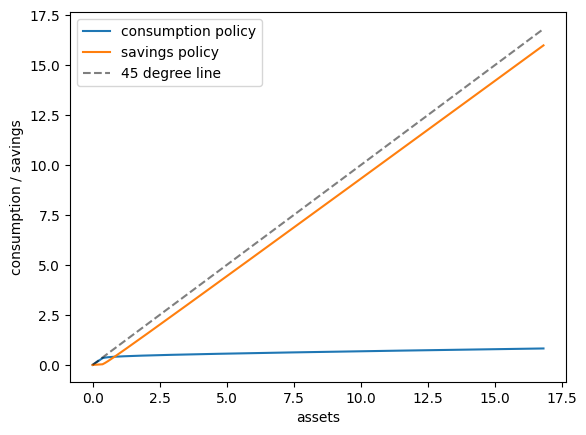

In [15]:
s_star = a_star - c_star

fig, ax = plt.subplots()
ax.plot(
   a_star,
   c_star,
   label="consumption policy"
)
ax.plot(
   a_star,
   s_star,
   label="savings policy"
)
ax.plot(a_star, a_star, 'k--', alpha=0.5, label="45 degree line")
ax.set_xlabel('assets')
ax.set_ylabel('consumption / savings')
plt.legend()
plt.show()

## Simulation

Having computed the optimal consumption policy, we can now simulate the model forward.

We start by simulating a single household over time to see how consumption and assets
evolve in response to random income shocks.

The household uses the optimal policy $\sigma^*$ to choose consumption at each date,
given current assets:

$$
    c_t = \sigma^*(a_t)
$$

Assets then evolve according to

$$
    a_{t+1} = R(a_t - c_t) + Y_{t+1}
$$

where $Y_{t+1}$ is the random income realization.

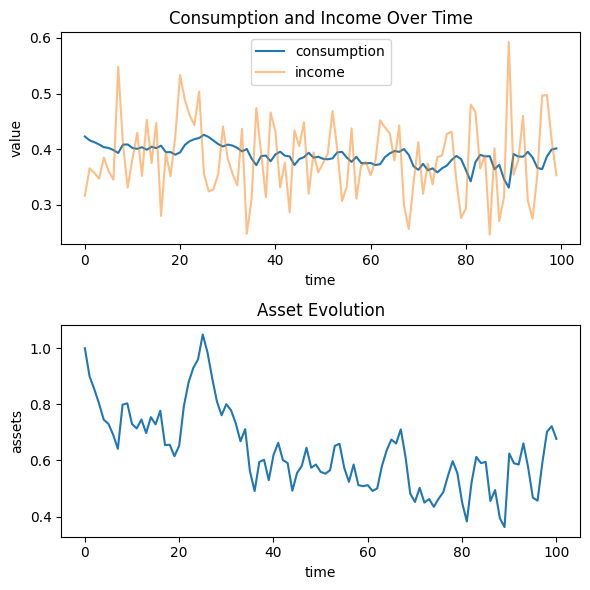

In [18]:
def simulate(model, a_grid, c_policy, a_0=1.0, T=100, seed=123):
    """
    Simulate the optimal consumption path.

    Parameters:
    -----------
    model : Model
        The model instance
    a_grid : array
        Grid of asset values from solution
    c_policy : array
        Optimal consumption policy on the grid
    a_0 : float
        Initial asset level
    T : int
        Number of periods to simulate
    seed : int
        Random seed for income shocks
    """

    # Generate income shocks for simulation
    key = jax.random.PRNGKey(seed)
    z_sim = jax.random.normal(key, (T,))
    y_sim = jnp.exp(model.μ + model.ν * z_sim)

    # Initialize arrays
    a_path = jnp.zeros(T+1)
    c_path = jnp.zeros(T)

    a_path = a_path.at[0].set(a_0)

    # Simulate forward
    for t in range(T):
        # Interpolate consumption policy
        c_t = jnp.interp(a_path[t], a_grid, c_policy)
        c_path = c_path.at[t].set(c_t)

        # Update assets
        s_t = a_path[t] - c_t
        a_path = a_path.at[t+1].set(model.R * s_t + y_sim[t])

    return a_path, c_path, y_sim

# Run simulation
a_path, c_path, y_path = simulate(model, a_star, c_star)

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))

# Plot consumption and income
ax1.plot(c_path, label='consumption')
ax1.plot(y_path, alpha=0.5, label='income')
ax1.set_xlabel('time')
ax1.set_ylabel('value')
ax1.set_title('Consumption and Income Over Time')
ax1.legend()

# Plot assets
ax2.plot(a_path)
ax2.set_xlabel('time')
ax2.set_ylabel('assets')
ax2.set_title('Asset Evolution')

plt.tight_layout()
plt.show()

## Cross-sectional distribution

The plot above shows the time series for a single household.

Now let's simulate a large cross-section of households to study the stationary
wealth distribution.

We simulate $N = 5_000$ households forward for $T = 500$ periods.

All households start with the same initial assets but face independent income
shocks drawn from the lognormal distribution.

Each household follows the same optimal policy $\sigma^*$, but the different
income realizations lead to heterogeneity in the wealth distribution.

The final cross-section of assets provides an approximation to the stationary
distribution of wealth under the optimal policy.


Simulating cross-section...


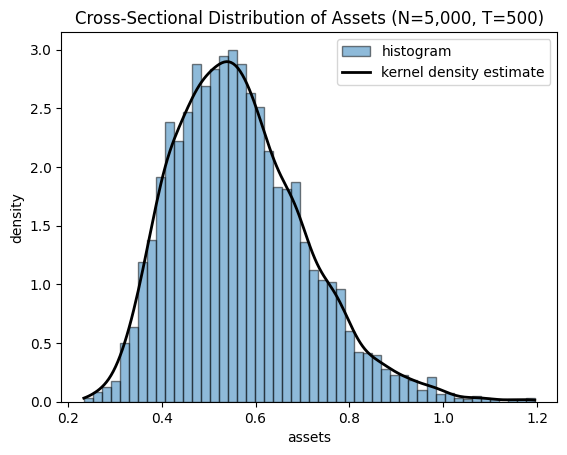

In [19]:
def simulate_cross_section(model, a_grid, c_policy, a_0=1.0, T=500, N=5_000, seed=456):
    """
    Simulate a cross-section of households.

    Parameters:
    -----------
    model : Model
        The model instance
    a_grid : array
        Grid of asset values from solution
    c_policy : array
        Optimal consumption policy on the grid
    a_0 : float
        Initial asset level for all households
    T : int
        Number of periods to simulate
    N : int
        Number of households
    seed : int
        Random seed for income shocks
    """

    # Generate income shocks for all households
    key = jax.random.PRNGKey(seed)
    z_sim = jax.random.normal(key, (N, T))
    y_sim = jnp.exp(model.μ + model.ν * z_sim)

    # Initialize asset holdings
    a_current = jnp.ones(N) * a_0

    # Simulate forward
    for t in range(T):
        # Interpolate consumption policy for all households
        c_current = jnp.interp(a_current, a_grid, c_policy)
        # Update assets
        s_current = a_current - c_current
        a_current = model.R * s_current + y_sim[:, t]

    return a_current

# Run cross-sectional simulation
print("Simulating cross-section...")
a_final = simulate_cross_section(model, a_star, c_star)

# Plot histogram with kernel density
from scipy.stats import gaussian_kde

fig, ax = plt.subplots()
ax.hist(a_final, bins=50, alpha=0.5, edgecolor='black', density=True, label='histogram')

# Add kernel density estimate
kde = gaussian_kde(a_final)
a_range = jnp.linspace(jnp.min(a_final), jnp.max(a_final), 200)
ax.plot(a_range, kde(a_range), 'k-', linewidth=2, label='kernel density estimate')

ax.set_xlabel('assets')
ax.set_ylabel('density')
ax.set_title('Cross-Sectional Distribution of Assets (N=5,000, T=500)')
ax.legend()
plt.show()